In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

---

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [297]:
from keras.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error as mse, mae, mape

---

In [3]:
file = pd.ExcelFile('Data.xlsx')
file.sheet_names

['RU',
 'US_USData',
 'US_FederalFundsEffectiveR',
 'US_CivilianEmpAndPopul',
 'US_GDP',
 'US_GovernConsumpExp&GrossInv',
 'US_RealGovernConsExp&GrossExp',
 'US_PersonalIncome&ItsDispos',
 'US_RealPersonalConsExp',
 'US_Savings&InvBySector',
 'US_RealPrivateFixInvByType',
 'US_PriceIndForPrivateFixInv']

In [4]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Graph
    plt.plot(list(timeseries))
    plt.show()

In [5]:
def diff_series(timeseries):
    diff_s = timeseries - timeseries.shift()
    return(diff_s[1:])

In [6]:
def plot_forecast(train, test, forc):
    '''
    train and test must be pd.DataFrame; forc must be ARIMAResult.forecast object
    '''
    # creating df for forecast
    df_forc = pd.DataFrame(forc[0], index=test.index, columns=['Forecast'])
    df_forc['std'] = forc[1]
    df_forc['conf_int_5'] = forc[2].T[0]
    df_forc['conf_int_95'] = forc[2].T[1]
    # plotting
    plt.figure(figsize=(9,5))
    plt.plot(train, label='Train_Sample')
    plt.plot(test, label='Test_Sample')
    plt.plot(df_forc['Forecast'], 'g')
    plt.plot(df_forc['conf_int_5'], 'k--', label='Confidence interval')
    plt.plot(df_forc['conf_int_95'], 'k--', label='_nolegend_')
    plt.legend(bbox_to_anchor=(1.4,1), loc='best')

In [212]:
def plot_forecast_out_only(test, forc, conf_int=True):
    '''
    test must be pd.DataFrame; forc must be ARIMAResult.forecast object
    '''
    # creating df for forecast
    df_forc = pd.DataFrame(forc[0], index=test.index, columns=['Forecast'])
    df_forc['std'] = forc[1]
    df_forc['conf_int_5'] = forc[2].T[0]
    df_forc['conf_int_95'] = forc[2].T[1]
    # plotting
    plt.figure(figsize=(7,4))
    plt.plot(test, label='Test_Sample')
    plt.plot(df_forc['Forecast'], 'g')
    if conf_int == True:
        plt.plot(df_forc['conf_int_5'], 'k--', label='Confidence interval')
        plt.plot(df_forc['conf_int_95'], 'k--', label='_nolegend_')
    plt.legend(bbox_to_anchor=(1.5,1), loc='best')

In [8]:
def time_line_creator(start_time, row_len):
    time = [1,2,3,4]*(row_len//4)
    t = 0
    for q in range(len(time)):
        str_q = str(start_time+t) + '_' + str(time[q])
        if time[q] == 4:
            t+=1
        time[q] = str_q
    return(time)

In [9]:
def create_df_for_nn(ts, n_lags):
    #create list of lists for df
    list_for_lags = []
    for i in range(n_lags, len(ts-1)):
        list_for_lags.append(ts[i-n_lags:i+1].tolist())
    #Cols and Indexes for df
    names_for_df = []
    for j in range(n_lags):
        names_for_df.append('x'+str(j))
    names_for_df.append('y')
    ind_for_df = ts.index[n_lags:]
    #creating df with cols and indexes
    df_for_nn = pd.DataFrame(list_for_lags)
    df_for_nn.columns = names_for_df
    df_for_nn.index = ind_for_df
    return(df_for_nn)

In [394]:
def create_df_for_nn_residuals(resid_series, n_lags):
    #create list of lists for df
    list_for_lags = []
    for i in range(n_lags, len(resid_series-1)):
        list_for_lags.append(resid_series[i-n_lags:i+1])
    #Cols for df
    names_for_df = []
    for j in range(n_lags):
        names_for_df.append('x'+str(j))
    names_for_df.append('y')
    #creating df with cols and indexes
    df_for_nn = pd.DataFrame(list_for_lags)
    df_for_nn.columns = names_for_df
    return(df_for_nn)

In [271]:
def nn_plot_in_sample(nn_model, train_nn):
    plt.plot(nn_model.predict(np.array(train_nn.iloc[:, :-1])), label='NN_Predict')
    plt.plot(np.array(train_nn.iloc[:, -1]), color='blue', label='Train_Sample')
    plt.legend(bbox_to_anchor=(1.5,1), loc='best')
    plt.show()

In [445]:
def nn_predict_series(nn_model, last_obs, lags_to_predict):
    '''
    last_obs - pandas df
    '''
    lags = len(last_obs.columns)
    predicted_obs = np.array(last_obs)[0].tolist() # list
    obs = np.array([predicted_obs]) # np.array
    for i in range(lags_to_predict):
        predicted_obs.append(nn_model.predict(obs)[0][0])
        obs = np.array([predicted_obs[-lags:]]) # np.array
    return(predicted_obs[lags:])

In [295]:
def nn_plot_out_sample(nn_model, train_nn, test):
    plt.plot(
        nn_predict_series(nn_model, 
                          train_nn.iloc[-1:, 1:], 
                          len(test))[len(train_nn.iloc[-1:, 1:].columns):],
        label='NN_Forecast'
    )
    plt.plot(list(test), color='blue', label='Test_Sample')
    plt.legend(bbox_to_anchor=(1.5,1), loc='best')
    plt.show()

In [453]:
def resid_df_for_nn(resids, test, n_lags):
    return(pd.DataFrame(resids[-len(test)-n_lags:-len(test)]).T)

# Russian_data

In [10]:
df_ru = file.parse('RU')

In [11]:
df_ru = df_ru.iloc[1:, :].copy()

In [12]:
df_ru.columns = time_line_creator(1995, len(df_ru.iloc[0,:]))

---

In [13]:
df_ru.iloc[:, :]

,1995_1,1995_2,1995_3,1995_4,1996_1,1996_2,1996_3,1996_4,1997_1,1997_2,...,2014_3,2014_4,2015_1,2015_2,2015_3,2015_4,2016_1,2016_2,2016_3,2016_4
Номинальные величины,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Валовой внутренний продукт,252.5,347,447.7,475.6,457,501.2,583.6,599.8,550.6,594,...,20406.9,21514.7,18209.7,19284.1,21294.4,22016.1,18561.3,19979.4,NaN,NaN
Расходы на конечное потребление,199.6,255.1,307,347.3,363.9,382.5,397.5,423.3,454.9,466.9,...,14462.9,15481.5,14029.2,14381.7,15085.4,15571,14394.5,14776.1,NaN,NaN
домашних хозяйств,140.8,181.3,220.7,249.3,257.1,269,281.3,303.3,316.1,323.3,...,10728.6,11613.9,10221.6,10477.3,11129.1,11503,10390.6,10701,NaN,NaN
государственного управления,54.4,68.3,80,90.7,98.5,104.7,107.2,110.8,127.7,132.2,...,3661.8,3792.7,3726.7,3821.9,3872.9,3981.9,3916.4,3986,NaN,NaN
"некоммерческих организаций, обслуживающих домашние хозяйства",4.3,5.5,6.3,7.2,8.3,8.9,8.9,9.2,11.1,11.4,...,72.5,74.9,80.9,82.5,83.4,86.1,87.5,89.1,NaN,NaN
Валовое накопление,30.6,68.2,130.3,129.1,72.6,89.7,168.1,138,82.5,106,...,5084.2,4987.9,2282.8,3341,5671.1,5466.5,2841.4,3894.9,NaN,NaN
валовое накопление основного капитала,29.8,61.5,75.7,133.7,63.1,78.7,97.5,161.8,76.7,89.9,...,4077.5,6432.4,2871.9,3662.2,4195.8,6937.9,2944.2,3829.9,NaN,NaN
изменение запасов материальных оборотных средств,0.7,6.7,54.5,-4.6,9.5,11.1,70.6,-23.8,5.8,16.1,...,1006.7,-1444.5,-589.1,-321.2,1475.3,-1471.4,-102.8,65,NaN,NaN
Чистый экспорт,18.9,20.6,6.2,5.8,13,17.5,20.5,36.7,21.6,11.9,...,980.1,1475.8,2314.4,1804.1,1063.3,1545.7,1309.9,1064.6,NaN,NaN


### Dirty (seasonal)

In [14]:
ru_gdp_ts = df_ru.iloc[1, :86] # Ru GDP Nominal

Results of Dickey-Fuller Test:
Test Statistic                  0.804535
p-value                         0.991709
#Lags Used                      8.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


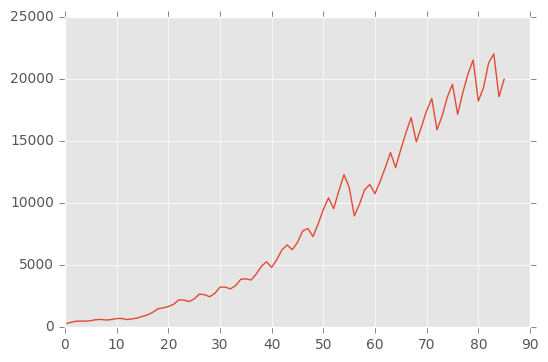

In [15]:
test_stationarity(ru_gdp_ts)

In [16]:
diff_ru_gdp_ts = ru_gdp_ts - ru_gdp_ts.shift()

Results of Dickey-Fuller Test:
Test Statistic                 -2.377038
p-value                         0.148323
#Lags Used                      7.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


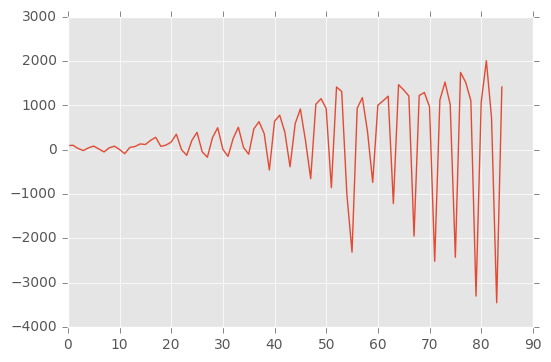

In [17]:
test_stationarity(diff_ru_gdp_ts[1:])

In [18]:
diff2_ru_gdp_ts = diff_ru_gdp_ts - diff_ru_gdp_ts.shift()

Results of Dickey-Fuller Test:
Test Statistic                 -4.953480
p-value                         0.000027
#Lags Used                     10.000000
Number of Observations Used    73.000000
Critical Value (1%)            -3.523284
Critical Value (5%)            -2.902031
Critical Value (10%)           -2.588371
dtype: float64


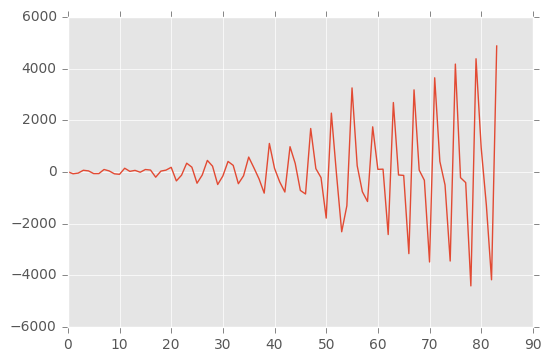

In [19]:
test_stationarity(diff2_ru_gdp_ts[2:])

### Pure

Nominal GDP

Results of Dickey-Fuller Test:
Test Statistic                  1.224718
p-value                         0.996152
#Lags Used                      1.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


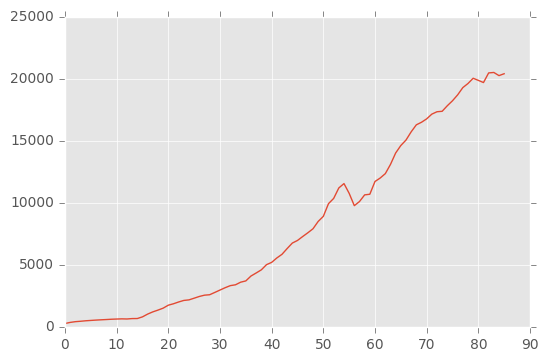

In [20]:
test_stationarity(df_ru.loc['ВВП номинальный', :'2016_2'])

Results of Dickey-Fuller Test:
Test Statistic                -5.886422e+00
p-value                        2.994183e-07
#Lags Used                     0.000000e+00
Number of Observations Used    8.400000e+01
Critical Value (1%)           -3.510712e+00
Critical Value (5%)           -2.896616e+00
Critical Value (10%)          -2.585482e+00
dtype: float64


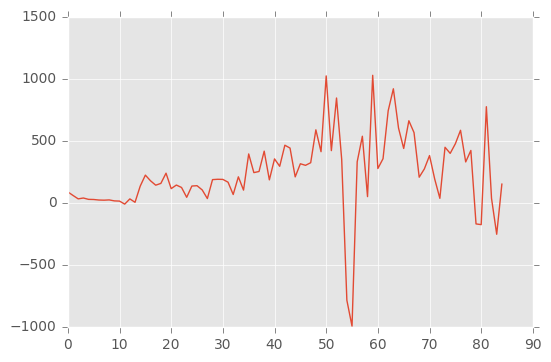

In [21]:
diff_ru_clear_gdp_ts = df_ru.loc['ВВП номинальный', :'2016_2'] - df_ru.loc['ВВП номинальный', :'2016_2'].shift()
test_stationarity(diff_ru_clear_gdp_ts[1:])

Real GDP

Results of Dickey-Fuller Test:
Test Statistic                 -0.775266
p-value                         0.826280
#Lags Used                      1.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


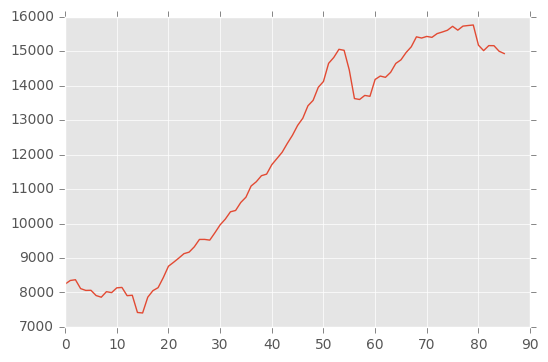

In [22]:
test_stationarity(df_ru.loc['ВВП реальный', :'2016_2'])

Results of Dickey-Fuller Test:
Test Statistic                -5.828238e+00
p-value                        4.031817e-07
#Lags Used                     0.000000e+00
Number of Observations Used    8.400000e+01
Critical Value (1%)           -3.510712e+00
Critical Value (5%)           -2.896616e+00
Critical Value (10%)          -2.585482e+00
dtype: float64


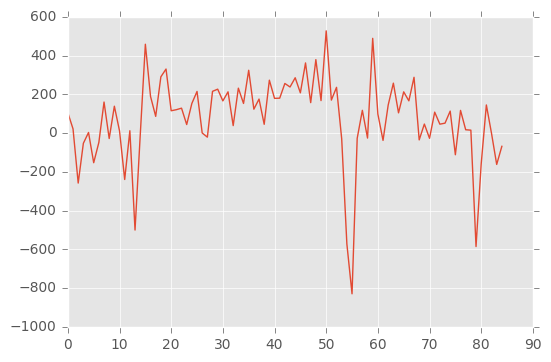

In [23]:
test_stationarity(diff_series(df_ru.loc['ВВП реальный', :'2016_2']))

Real consumption of hoseholds

Results of Dickey-Fuller Test:
Test Statistic                 -1.468031
p-value                         0.549263
#Lags Used                      5.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64


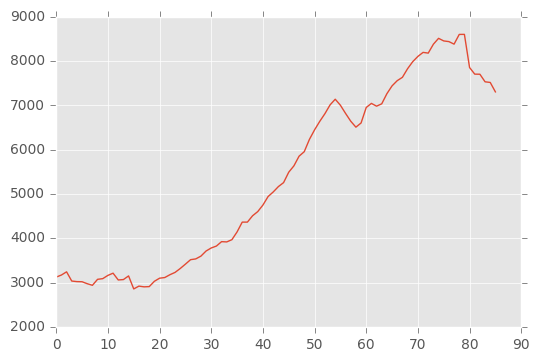

In [24]:
test_stationarity(df_ru.loc['Потребление дх', :'2016_2'].iloc[1,:])

Results of Dickey-Fuller Test:
Test Statistic                 -1.988112
p-value                         0.291810
#Lags Used                      4.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64


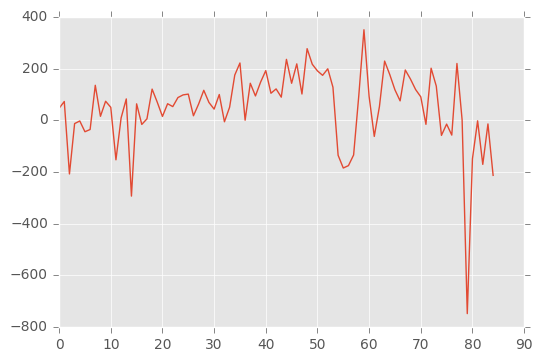

In [25]:
test_stationarity(diff_series(df_ru.loc['Потребление дх', :'2016_2'].iloc[1,:]))

Results of Dickey-Fuller Test:
Test Statistic                -8.093856e+00
p-value                        1.355515e-12
#Lags Used                     3.000000e+00
Number of Observations Used    8.000000e+01
Critical Value (1%)           -3.514869e+00
Critical Value (5%)           -2.898409e+00
Critical Value (10%)          -2.586439e+00
dtype: float64


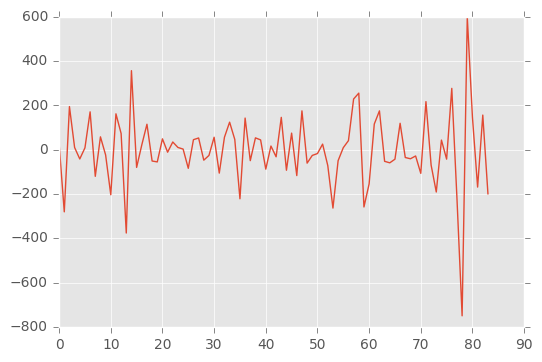

In [26]:
test_stationarity(diff_series(diff_series(df_ru.loc['Потребление дх', :'2016_2'].iloc[1,:])))

Real Export

Results of Dickey-Fuller Test:
Test Statistic                 -0.903524
p-value                         0.786810
#Lags Used                      2.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


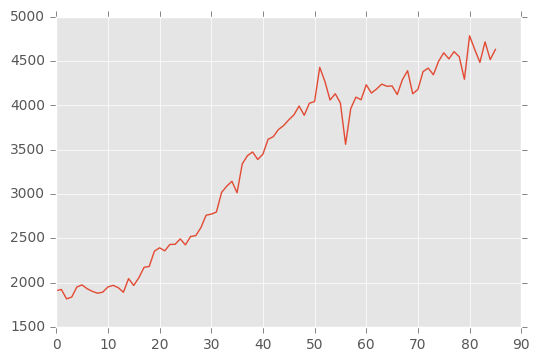

In [27]:
test_stationarity(df_ru.loc['Экспорт', :'2016_2'].iloc[2,:])

Results of Dickey-Fuller Test:
Test Statistic                -1.024904e+01
p-value                        4.536603e-18
#Lags Used                     1.000000e+00
Number of Observations Used    8.300000e+01
Critical Value (1%)           -3.511712e+00
Critical Value (5%)           -2.897048e+00
Critical Value (10%)          -2.585713e+00
dtype: float64


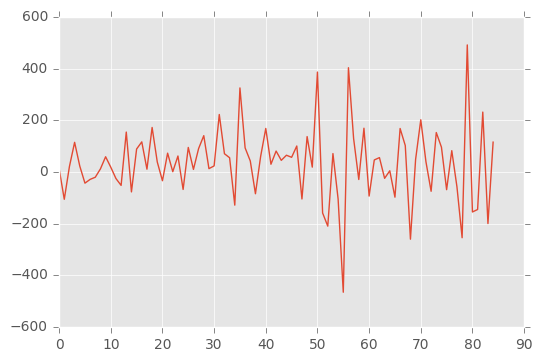

In [28]:
test_stationarity(diff_series(df_ru.loc['Экспорт', :'2016_2'].iloc[2,:]))

Real Import

Results of Dickey-Fuller Test:
Test Statistic                 -1.263000
p-value                         0.645925
#Lags Used                      1.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


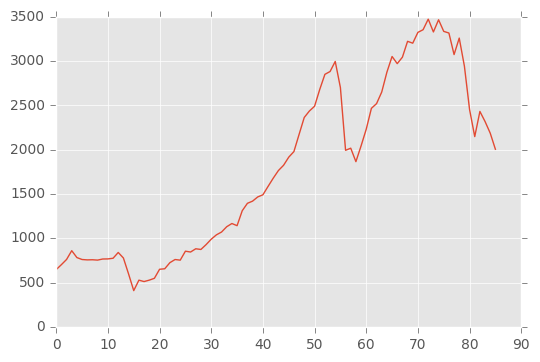

In [29]:
test_stationarity(df_ru.loc['Импорт реальный', :'2016_2'])

Results of Dickey-Fuller Test:
Test Statistic                -6.775964e+00
p-value                        2.570413e-09
#Lags Used                     0.000000e+00
Number of Observations Used    8.400000e+01
Critical Value (1%)           -3.510712e+00
Critical Value (5%)           -2.896616e+00
Critical Value (10%)          -2.585482e+00
dtype: float64


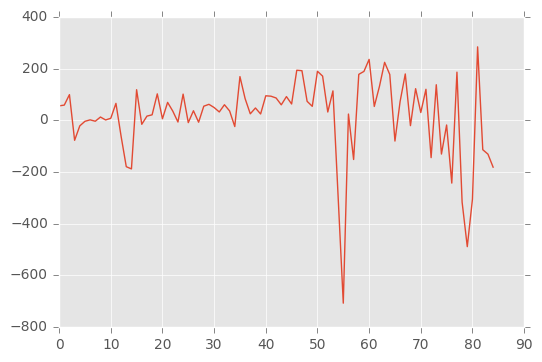

In [30]:
test_stationarity(diff_series(df_ru.loc['Импорт реальный', :'2016_2']))

# US_CivilianEmpAndPopul

In [31]:
df_US_CivEmpPopul = file.parse('US_CivilianEmpAndPopul')

In [32]:
df_CivEmp = df_US_CivEmpPopul.iloc[7:, :2].copy()
df_CivEmp.columns = ['observation_date', 'civilian_employment']
df_CivEmp = df_CivEmp.iloc[1:, :]
df_CivEmp.index = df_CivEmp['observation_date']
df_CivEmp = df_CivEmp.iloc[:, 1]

Results of Dickey-Fuller Test:
Test Statistic                  -0.004248
p-value                          0.958179
#Lags Used                      12.000000
Number of Observations Used    795.000000
Critical Value (1%)             -3.438602
Critical Value (5%)             -2.865182
Critical Value (10%)            -2.568710
dtype: float64


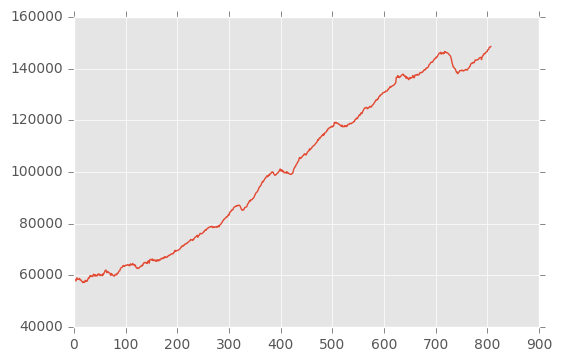

In [33]:
test_stationarity(df_CivEmp)

Results of Dickey-Fuller Test:
Test Statistic                -6.087563e+00
p-value                        1.055390e-07
#Lags Used                     1.100000e+01
Number of Observations Used    7.950000e+02
Critical Value (1%)           -3.438602e+00
Critical Value (5%)           -2.865182e+00
Critical Value (10%)          -2.568710e+00
dtype: float64


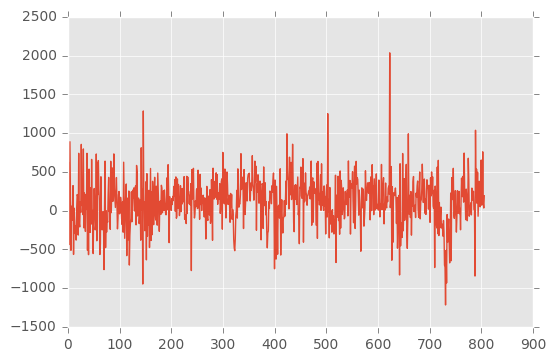

In [34]:
test_stationarity(diff_series(df_CivEmp))

In [35]:
df_PopEmp = df_US_CivEmpPopul.iloc[7:, 2:].copy()
df_PopEmp.columns = ['observation_date', 'civilian_employment']
df_PopEmp = df_PopEmp.iloc[1:, :]
df_PopEmp.index = df_PopEmp['observation_date']
df_PopEmp = df_PopEmp.iloc[:, 1]

Results of Dickey-Fuller Test:
Test Statistic                   3.057063
p-value                          1.000000
#Lags Used                       7.000000
Number of Observations Used    800.000000
Critical Value (1%)             -3.438551
Critical Value (5%)             -2.865160
Critical Value (10%)            -2.568697
dtype: float64


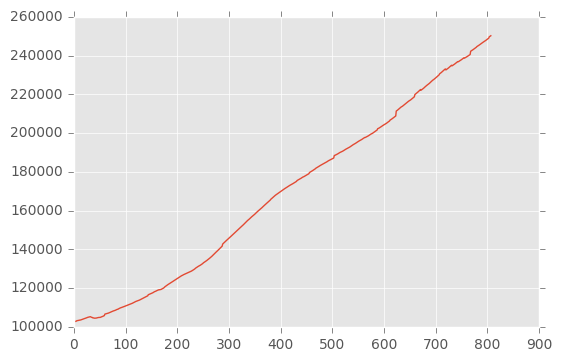

In [36]:
test_stationarity(df_PopEmp)

Results of Dickey-Fuller Test:
Test Statistic                -5.968400e+00
p-value                        1.962630e-07
#Lags Used                     8.000000e+00
Number of Observations Used    7.980000e+02
Critical Value (1%)           -3.438571e+00
Critical Value (5%)           -2.865169e+00
Critical Value (10%)          -2.568702e+00
dtype: float64


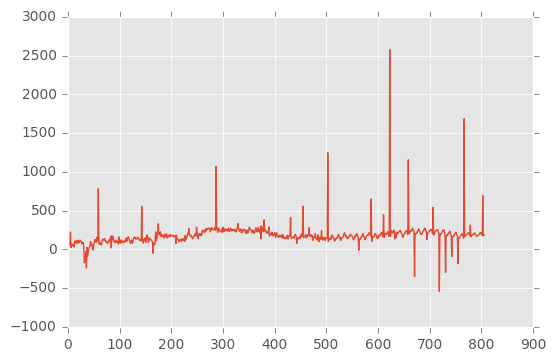

In [37]:
test_stationarity(diff_series(df_PopEmp))

# US_RealGovernConsExp&GrossExp

In [38]:
US_RealGovExp = file.parse('US_RealGovernConsExp&GrossExp')

In [39]:
ind = US_RealGovExp.iloc[8:49, 1].tolist()
col = time_line_creator(1999, len(US_RealGovExp.iloc[:, 3:].columns)+3)[:-3]

In [40]:
df_US_RealGovExp = US_RealGovExp.iloc[8:49, 3:].copy()
df_US_RealGovExp.index = ind
df_US_RealGovExp.columns = col

---

National defense

Results of Dickey-Fuller Test:
Test Statistic                 -2.036819
p-value                         0.270666
#Lags Used                     11.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


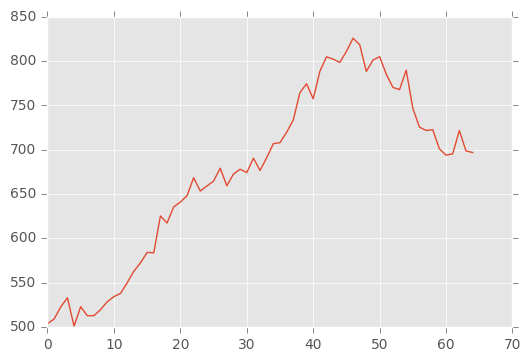

In [41]:
test_stationarity(df_US_RealGovExp.loc['  National defense', :])

Results of Dickey-Fuller Test:
Test Statistic                 -2.543160
p-value                         0.105323
#Lags Used                     10.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


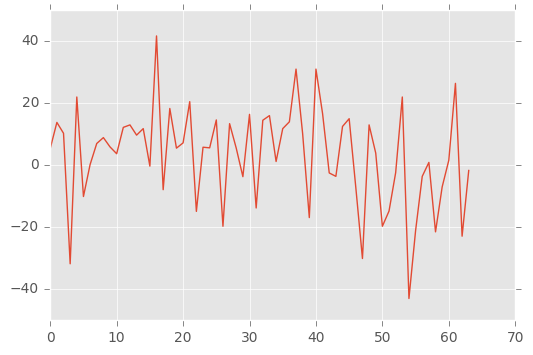

In [42]:
test_stationarity(diff_series(df_US_RealGovExp.loc['  National defense', :]))

Government consumption expenditures and gross investment

Results of Dickey-Fuller Test:
Test Statistic                 -2.775523
p-value                         0.061856
#Lags Used                      6.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64


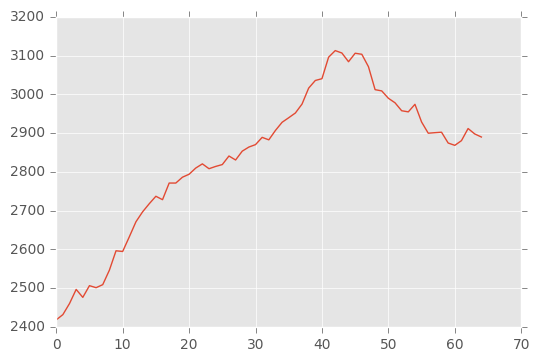

In [43]:
test_stationarity(df_US_RealGovExp.loc['    Government consumption expenditures and gross investment', :])

Results of Dickey-Fuller Test:
Test Statistic                 -1.787689
p-value                         0.386591
#Lags Used                      7.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


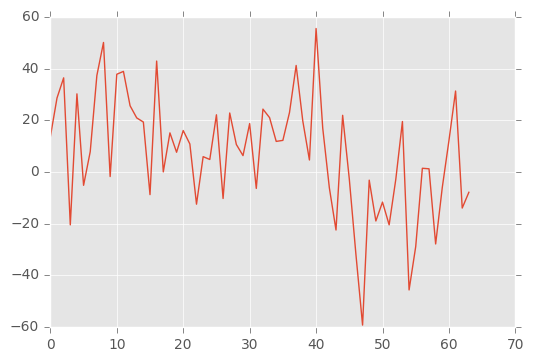

In [44]:
test_stationarity(
    diff_series(df_US_RealGovExp.loc['    Government consumption expenditures and gross investment', :])
)

Results of Dickey-Fuller Test:
Test Statistic                 -3.495373
p-value                         0.008107
#Lags Used                      6.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


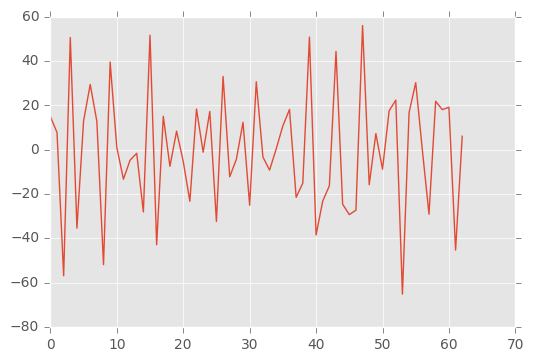

In [45]:
test_stationarity(
    diff_series(
    diff_series(df_US_RealGovExp.loc['    Government consumption expenditures and gross investment', :])
        )
)

# US Federal effective rate

In [46]:
df_us_fed_ef_r = file.parse('US_FederalFundsEffectiveR')

In [47]:
tf_ef_r = df_us_fed_ef_r.iloc[5:, :]
tf_ef_r.index = tf_ef_r['Series Description']

In [48]:
tf_ef_r = tf_ef_r['Federal funds effective rate']

In [49]:
tf_ef_r.index.name = None

Results of Dickey-Fuller Test:
Test Statistic                  -2.682761
p-value                          0.077069
#Lags Used                      17.000000
Number of Observations Used    713.000000
Critical Value (1%)             -3.439555
Critical Value (5%)             -2.865602
Critical Value (10%)            -2.568933
dtype: float64


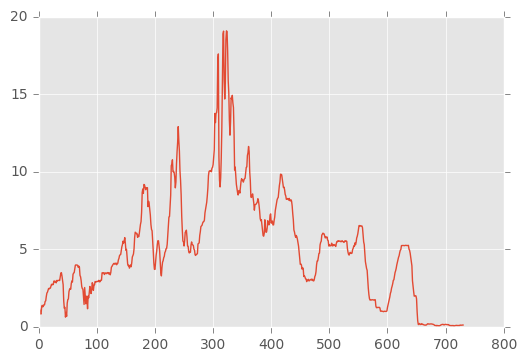

In [50]:
test_stationarity(tf_ef_r)

In [51]:
diff_tf_ef_r = diff_series(tf_ef_r)

Results of Dickey-Fuller Test:
Test Statistic                -5.984594e+00
p-value                        1.804735e-07
#Lags Used                     1.800000e+01
Number of Observations Used    7.110000e+02
Critical Value (1%)           -3.439581e+00
Critical Value (5%)           -2.865614e+00
Critical Value (10%)          -2.568939e+00
dtype: float64


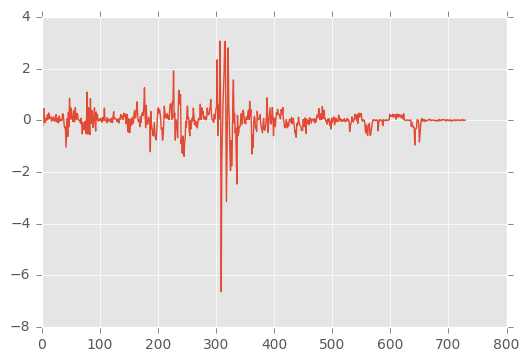

In [52]:
test_stationarity(diff_tf_ef_r)

### ARIMA part

In [53]:
from statsmodels.tsa.arima_model import ARIMA

In [54]:
import statsmodels.api as sm

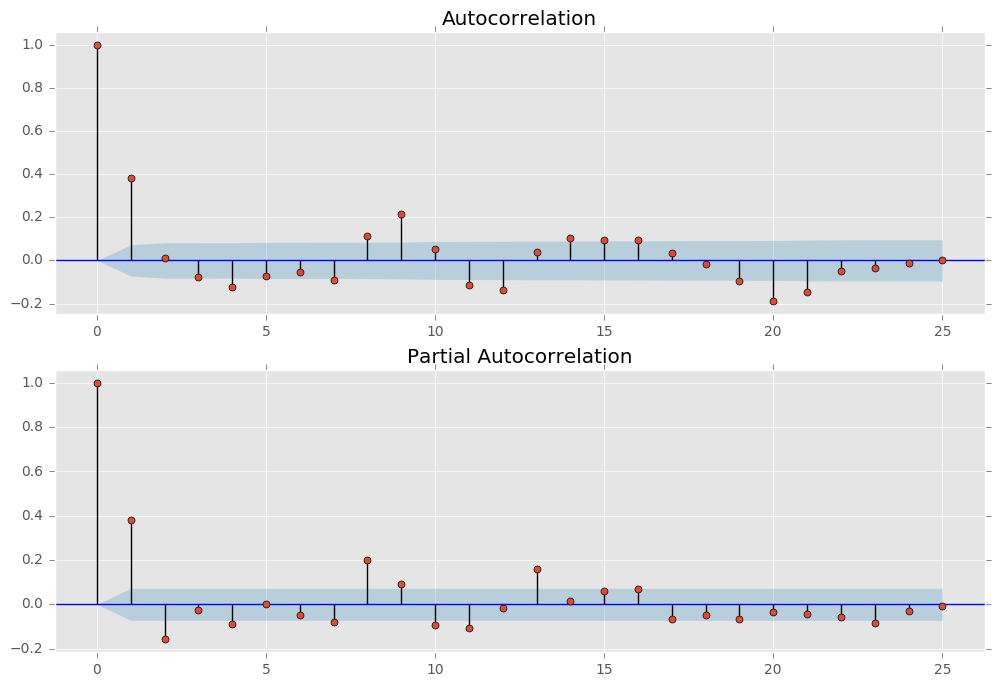

In [275]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(list(diff_tf_ef_r[1:]), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(list(diff_tf_ef_r[1:]), lags=25, ax=ax2)

In [276]:
tf_ef_r.index = pd.DatetimeIndex(start='1954-07', end='2015-06', freq='M')

In [277]:
len(tf_ef_r)

731

In [278]:
train = tf_ef_r[:723]
test = tf_ef_r[723:]

In [279]:
test

2014-10-31    0.09
2014-11-30    0.09
2014-12-31    0.12
2015-01-31    0.11
2015-02-28    0.11
2015-03-31    0.11
2015-04-30    0.12
2015-05-31    0.12
Freq: M, Name: Federal funds effective rate, dtype: object

In [322]:
model = ARIMA(np.array(train), order=(2,1,1)).fit(trend='nc')

In [281]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  722
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -482.677
Method:                       css-mle   S.D. of innovations              0.472
Date:                Thu, 26 Jan 2017   AIC                            973.353
Time:                        01:18:22   BIC                            991.682
Sample:                             1   HQIC                           980.428
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.D.y      0.9107      0.161      5.662      0.000         0.595     1.226
ar.L2.D.y     -0.3278      0.059     -5.600      0.000        -0.443    -0.213
ma.L1.D.y     -0.4868      0.168     -2.905      0.0

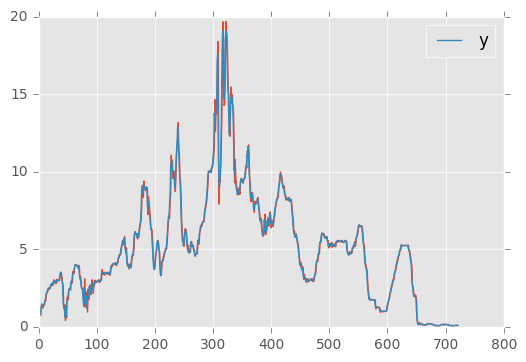

In [348]:
model.plot_predict()
plt.show()

In [283]:
forc_arima = model.forecast(len(test))

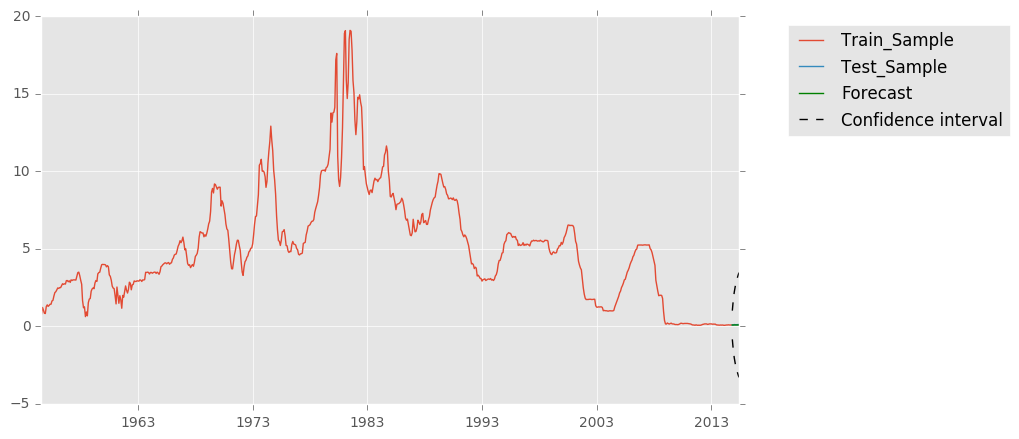

In [284]:
plot_forecast(train, test, forc_arima)

In [285]:
test

2014-10-31    0.09
2014-11-30    0.09
2014-12-31    0.12
2015-01-31    0.11
2015-02-28    0.11
2015-03-31    0.11
2015-04-30    0.12
2015-05-31    0.12
Freq: M, Name: Federal funds effective rate, dtype: object

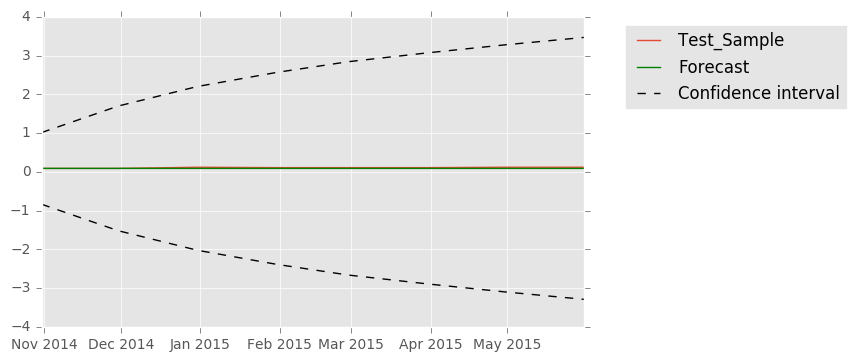

In [286]:
plot_forecast_out_only(test, forc_arima)

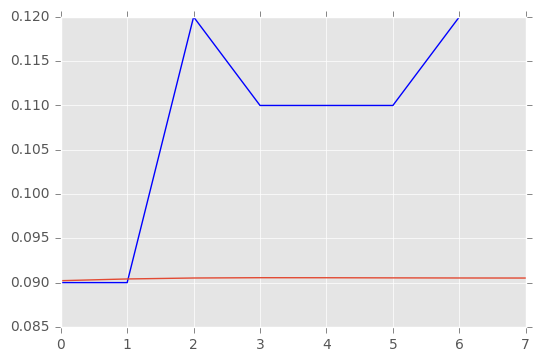

In [287]:
plt.plot(list(test), color='blue')
plt.plot(forc_arima[0])
plt.show()

### ANN part

In [398]:
train_nn = create_df_for_nn(tf_ef_r, 2).loc[:'2014-09-30', :]

In [399]:
def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

In [400]:
nn = assemble_model(2)

In [401]:
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=200, 
       verbose=2,
       batch_size=1)

Epoch 1/200
1s - loss: 26.1909
Epoch 2/200
1s - loss: 12.8503
Epoch 3/200
1s - loss: 9.8478
Epoch 4/200
1s - loss: 6.2409
Epoch 5/200
1s - loss: 3.5227
Epoch 6/200
1s - loss: 2.2218
Epoch 7/200
1s - loss: 1.5799
Epoch 8/200
1s - loss: 1.2432
Epoch 9/200
1s - loss: 1.0279
Epoch 10/200
1s - loss: 0.8712
Epoch 11/200
1s - loss: 0.7560
Epoch 12/200
1s - loss: 0.6784
Epoch 13/200
1s - loss: 0.6070
Epoch 14/200
1s - loss: 0.5405
Epoch 15/200
1s - loss: 0.4711
Epoch 16/200
1s - loss: 0.4147
Epoch 17/200
1s - loss: 0.3598
Epoch 18/200
1s - loss: 0.3225
Epoch 19/200
1s - loss: 0.3025
Epoch 20/200
1s - loss: 0.3056
Epoch 21/200
1s - loss: 0.2925
Epoch 22/200
1s - loss: 0.2723
Epoch 23/200
1s - loss: 0.2655
Epoch 24/200
1s - loss: 0.2677
Epoch 25/200
1s - loss: 0.2676
Epoch 26/200
1s - loss: 0.2621
Epoch 27/200
1s - loss: 0.2517
Epoch 28/200
1s - loss: 0.2458
Epoch 29/200
1s - loss: 0.2675
Epoch 30/200
1s - loss: 0.2376
Epoch 31/200
1s - loss: 0.2418
Epoch 32/200
1s - loss: 0.2450
Epoch 33/200
1s

KeyboardInterrupt: 

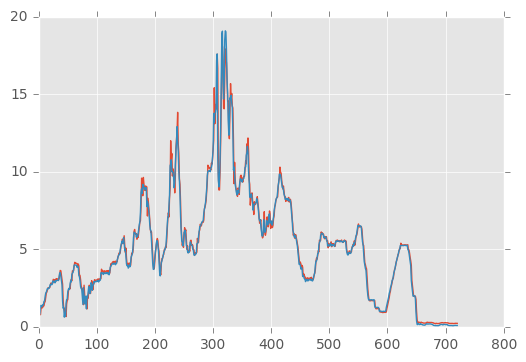

In [402]:
plt.plot(nn.predict(np.array(train_nn.iloc[:, :-1])))
plt.plot(np.array(train_nn.iloc[:, -1]))
plt.show()

In [144]:
train_nn.iloc[-1:, 1:]

,x1,x2,x3,x4,x5,x6,x7,x8,x9,y
2014-09-30,0.09,0.07,0.07,0.08,0.09,0.09,0.1,0.09,0.09,0.09


In [145]:
nn.predict(np.array(train_nn.iloc[-1:, 1:]))[0][0]

0.19720423

In [146]:
len(test)

8

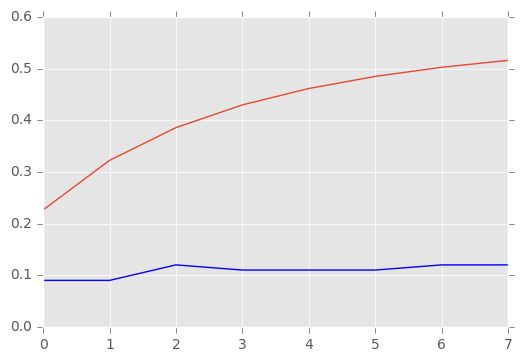

In [403]:
plt.plot(nn_predict_series(nn, train_nn.iloc[-1:, 1:], len(test))[len(train_nn.iloc[-1:, 1:].columns):])
plt.plot(list(test), color='blue')
plt.show()

### Hybrid

In [307]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  722
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -482.677
Method:                       css-mle   S.D. of innovations              0.472
Date:                Thu, 26 Jan 2017   AIC                            973.353
Time:                        01:44:57   BIC                            991.682
Sample:                             1   HQIC                           980.428
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.D.y      0.9107      0.161      5.662      0.000         0.595     1.226
ar.L2.D.y     -0.3278      0.059     -5.600      0.000        -0.443    -0.213
ma.L1.D.y     -0.4868      0.168     -2.905      0.0

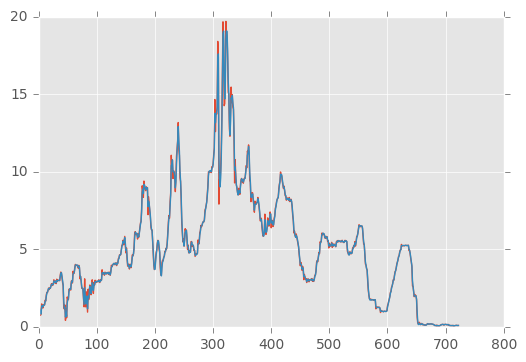

In [390]:
plt.plot(model.predict(end=723, typ='levels'))
plt.plot(list(train))
plt.show()

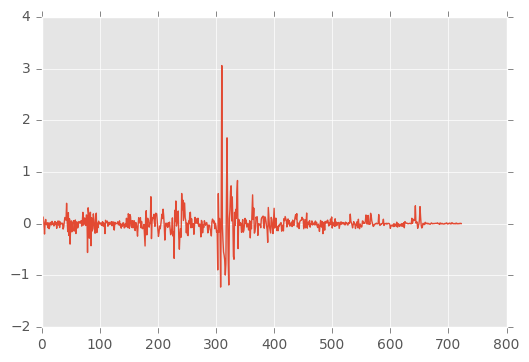

In [463]:
residuals_in_sample = np.array(train) - model.predict(end=len(train), typ='levels')
plt.plot(residuals_in_sample)
plt.show()

In [397]:
df_nn_resid = create_df_for_nn_residuals(residuals_in_sample[1:], 2)

In [404]:
def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

In [410]:
nn_resid = assemble_model(2)
nn_resid.fit(np.array(df_nn_resid.iloc[:, :-1]), 
       np.array(df_nn_resid.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
1s - loss: 0.1450
Epoch 2/100
1s - loss: 0.0463
Epoch 3/100
1s - loss: 0.0460
Epoch 4/100
1s - loss: 0.0458
Epoch 5/100
1s - loss: 0.0456
Epoch 6/100
1s - loss: 0.0455
Epoch 7/100
1s - loss: 0.0446
Epoch 8/100
1s - loss: 0.0450
Epoch 9/100
1s - loss: 0.0444
Epoch 10/100
1s - loss: 0.0439
Epoch 11/100
1s - loss: 0.0438
Epoch 12/100
1s - loss: 0.0444
Epoch 13/100
1s - loss: 0.0436
Epoch 14/100
1s - loss: 0.0436
Epoch 15/100
1s - loss: 0.0438
Epoch 16/100
1s - loss: 0.0439
Epoch 17/100
1s - loss: 0.0431
Epoch 18/100
1s - loss: 0.0436
Epoch 19/100
1s - loss: 0.0428
Epoch 20/100
1s - loss: 0.0425
Epoch 21/100
1s - loss: 0.0433
Epoch 22/100
1s - loss: 0.0431
Epoch 23/100
1s - loss: 0.0432
Epoch 24/100
1s - loss: 0.0430
Epoch 25/100
1s - loss: 0.0429
Epoch 26/100
1s - loss: 0.0431
Epoch 27/100
1s - loss: 0.0429
Epoch 28/100
1s - loss: 0.0429
Epoch 29/100
1s - loss: 0.0434
Epoch 30/100
1s - loss: 0.0427
Epoch 31/100
1s - loss: 0.0429
Epoch 32/100
1s - loss: 0.0428
Epoch 33/100
1s -

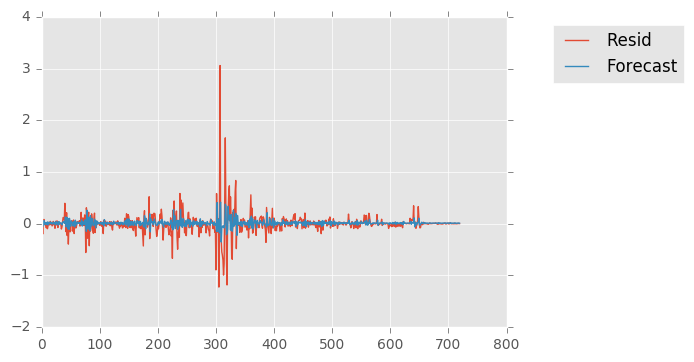

In [416]:
plt.plot(np.array(df_nn_resid.iloc[:, -1]), label='Resid')
plt.plot(nn_resid.predict(np.array(df_nn_resid.iloc[:, :-1])), label='Forecast')
plt.legend(bbox_to_anchor=(1.4,1), loc='best')
plt.show()

In [433]:
pd.DataFrame(residuals_in_sample[-10:-8]).T

,0,1
0,-0.00512921,0.00925875


In [461]:
resid_df_for_nn(residuals_in_sample, test, 2)

,0,1
0,-0.00512921,0.00925875


In [446]:
nn_resid_forecast = nn_predict_series(nn_resid, pd.DataFrame(residuals_in_sample[-10:-8]).T, len(test))

In [464]:
nn_resid_forecast

[0.012034193,
 0.0095700622,
 0.0081368685,
 0.0082517117,
 0.0086213797,
 0.0087128133,
 0.0086560547,
 0.0086166412]

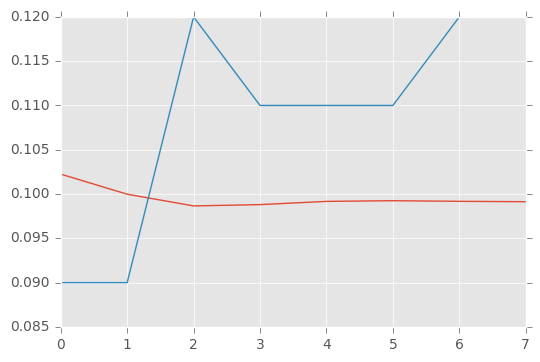

In [450]:
plt.plot(forc_arima[0] + np.array(nn_resid_forecast))
plt.plot(list(test))

## Real Export (higher)

In [55]:
real_exp = df_ru.loc['Экспорт', :'2016_2'].iloc[2,:]

In [56]:
real_exp.index = pd.DatetimeIndex(start='1995-01', end='2016-07', freq='Q')

Results of Dickey-Fuller Test:
Test Statistic                 -0.903524
p-value                         0.786810
#Lags Used                      2.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


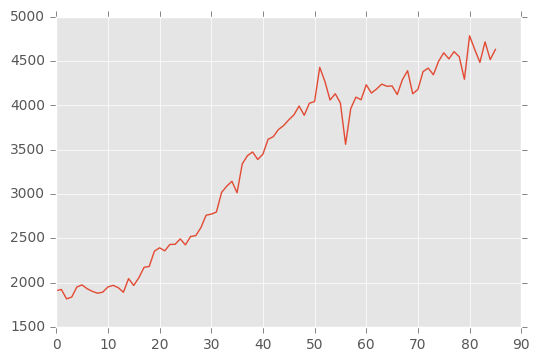

In [57]:
test_stationarity(real_exp)

Results of Dickey-Fuller Test:
Test Statistic                -1.024904e+01
p-value                        4.536603e-18
#Lags Used                     1.000000e+00
Number of Observations Used    8.300000e+01
Critical Value (1%)           -3.511712e+00
Critical Value (5%)           -2.897048e+00
Critical Value (10%)          -2.585713e+00
dtype: float64


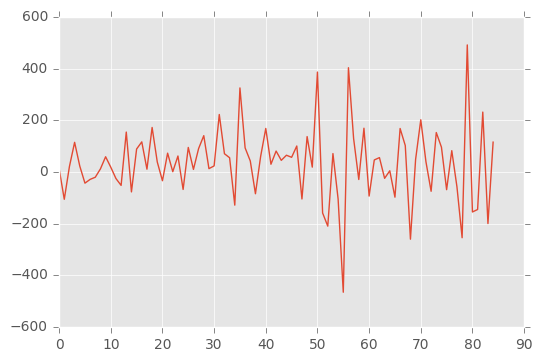

In [58]:
test_stationarity(diff_series(real_exp))

### ARIMA part

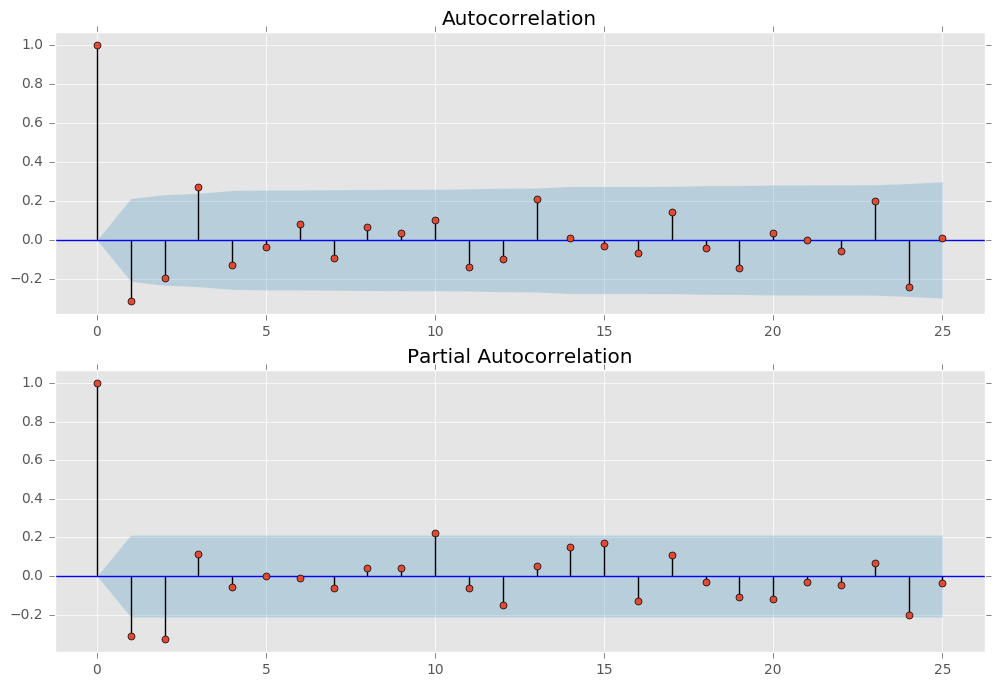

In [59]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(list(diff_series(real_exp)), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(list(diff_series(real_exp)), lags=25, ax=ax2)

In [60]:
len(real_exp)*0.85, len(real_exp)

(73.1, 86)

In [255]:
train = real_exp[:81]
test = real_exp[81:]

In [256]:
model = ARIMA(np.array(train), order=(2,1,1)).fit(trend='nc')

In [257]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   80
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -507.284
Method:                       css-mle   S.D. of innovations            137.136
Date:                Wed, 25 Jan 2017   AIC                           1022.567
Time:                        22:55:29   BIC                           1032.095
Sample:                             1   HQIC                          1026.387
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.D.y     -0.6136      0.266     -2.305      0.024        -1.135    -0.092
ar.L2.D.y     -0.3048      0.118     -2.590      0.011        -0.535    -0.074
ma.L1.D.y      0.4011      0.257      1.560      0.1

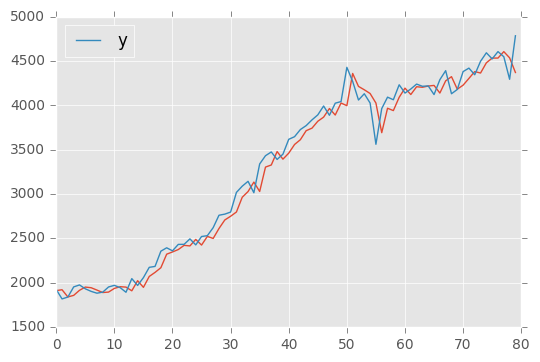

In [258]:
model.plot_predict()
plt.show()

In [259]:
forc_arima = model.forecast(len(test))

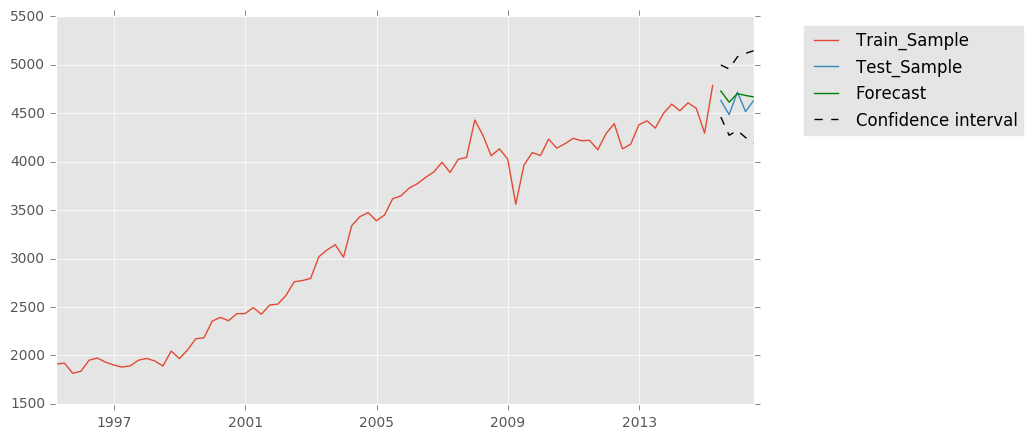

In [260]:
plot_forecast(train, test, forc_arima)

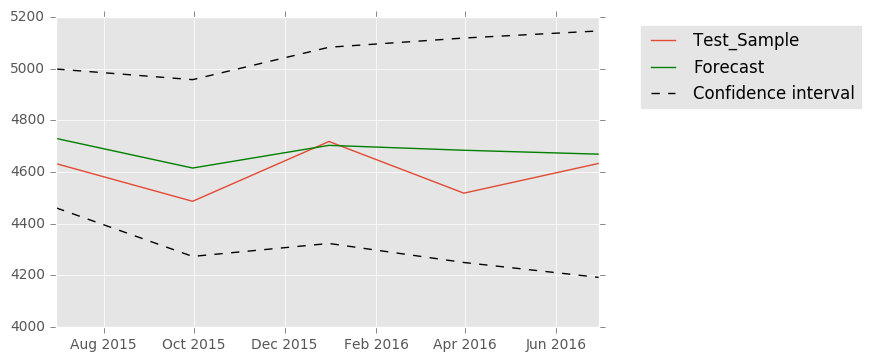

In [261]:
plot_forecast_out_only(test, forc_arima)

### ANN part

In [185]:
train_nn = create_df_for_nn(real_exp, 2).loc[:'2013-03-31', :]

In [186]:
len(real_exp),len(train_nn)

(86, 71)

In [187]:
def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    adam = Adam(lr=0.1)
    model.compile(loss='mean_squared_error', optimizer=adam)
    return(model)

In [188]:
nn = assemble_model(2)
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=200, 
       verbose=2,
       batch_size=1)

Epoch 1/200
1s - loss: 10777822.0951
Epoch 2/200
0s - loss: 10443234.4401
Epoch 3/200
0s - loss: 9989606.2535
Epoch 4/200
0s - loss: 9506365.5669
Epoch 5/200
0s - loss: 9002601.1549
Epoch 6/200
0s - loss: 8545755.7007
Epoch 7/200
0s - loss: 8127847.4489
Epoch 8/200
0s - loss: 7735638.6514
Epoch 9/200
0s - loss: 7364752.8011
Epoch 10/200
0s - loss: 7011190.8187
Epoch 11/200
0s - loss: 6673965.5722
Epoch 12/200
0s - loss: 6352997.3979
Epoch 13/200
0s - loss: 6046568.5211
Epoch 14/200
0s - loss: 5752327.1963
Epoch 15/200
0s - loss: 5473136.1928
Epoch 16/200
0s - loss: 5205488.4437
Epoch 17/200
0s - loss: 4951750.4036
Epoch 18/200
0s - loss: 4707071.6237
Epoch 19/200
0s - loss: 4475369.0761
Epoch 20/200
0s - loss: 4255705.6140
Epoch 21/200
0s - loss: 4043229.0552
Epoch 22/200
0s - loss: 3843518.9093
Epoch 23/200
0s - loss: 3651764.3851
Epoch 24/200
0s - loss: 3470618.1710
Epoch 25/200
0s - loss: 3296351.3460
Epoch 26/200
0s - loss: 3133612.6667
Epoch 27/200
0s - loss: 2977578.3228
Epoch 28

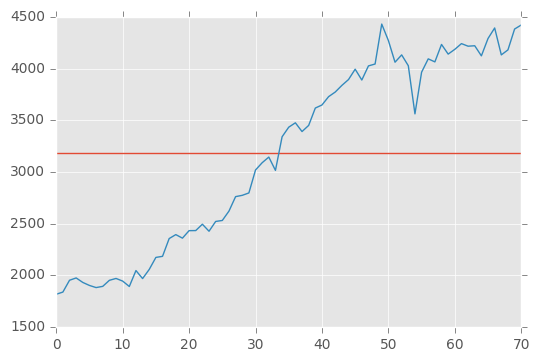

In [189]:
plt.plot(nn.predict(np.array(train_nn.iloc[:, :-1])))
plt.plot(np.array(train_nn.iloc[:, -1]))
plt.show()

In [174]:
create_df_for_nn(real_exp, 2).loc[:'2013-03-31', :]

,x0,x1,y
1995-09-30,1909.412651,1921.926896,1815.838152
1995-12-31,1921.926896,1815.838152,1836.915094
1996-03-31,1815.838152,1836.915094,1951.320460
1996-06-30,1836.915094,1951.320460,1973.718584
1996-09-30,1951.320460,1973.718584,1930.137774
1996-12-31,1973.718584,1930.137774,1901.110229
1997-03-31,1930.137774,1901.110229,1880.419772
1997-06-30,1901.110229,1880.419772,1892.138929
1997-09-30,1880.419772,1892.138929,1950.691982
1997-12-31,1892.138929,1950.691982,1968.866513


# Real Personal Consumption Expenditures by Major Type of Product, Quantity Indexes

In [123]:
US_RealPersConsExp = file.parse('US_RealPersonalConsExp')

In [132]:
ind = US_RealPersConsExp.iloc[8:37, 1].tolist()

In [147]:
col = time_line_creator(1969, 188)[:-3]

In [148]:
df_US_RealPersConsExp = US_RealPersConsExp.iloc[8:37, 3:].copy()

In [149]:
df_US_RealPersConsExp.columns = col
df_US_RealPersConsExp.index = ind

In [153]:
hh_cons_exp_serv = df_US_RealPersConsExp.loc['  Household consumption expenditures (for services)', :]

In [272]:
test = hh_cons_exp_serv[176:]

In [273]:
test

2013_1    105.506
2013_2    106.044
2013_3    106.322
2013_4    107.232
2014_1    107.605
2014_2    107.811
2014_3    108.417
2014_4    109.646
2015_1     110.47
Name:   Household consumption expenditures (for services), dtype: object

In [263]:
train_nn = create_df_for_nn(hh_cons_exp_serv, 2).loc[:'2012_4', :]

In [264]:
def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    #sgd = SGD(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

In [266]:
nn = assemble_model(2)
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=300, 
       verbose=2,
       batch_size=1)

Epoch 1/300
0s - loss: 4741.2882
Epoch 2/300
0s - loss: 4487.0571
Epoch 3/300
0s - loss: 4292.8229
Epoch 4/300
0s - loss: 4120.5685
Epoch 5/300
0s - loss: 3961.2749
Epoch 6/300
0s - loss: 3810.9926
Epoch 7/300
0s - loss: 3667.5906
Epoch 8/300
0s - loss: 3529.2459
Epoch 9/300
0s - loss: 3394.0719
Epoch 10/300
0s - loss: 3227.7988
Epoch 11/300
0s - loss: 3060.5649
Epoch 12/300
0s - loss: 2916.8522
Epoch 13/300
0s - loss: 2783.7088
Epoch 14/300
0s - loss: 2658.2316
Epoch 15/300
0s - loss: 2523.2681
Epoch 16/300
0s - loss: 2308.3352
Epoch 17/300
0s - loss: 2142.7945
Epoch 18/300
0s - loss: 2009.1124
Epoch 19/300
0s - loss: 1889.8683
Epoch 20/300
0s - loss: 1781.5809
Epoch 21/300
0s - loss: 1681.5399
Epoch 22/300
0s - loss: 1589.2389
Epoch 23/300
0s - loss: 1503.3245
Epoch 24/300
0s - loss: 1423.4447
Epoch 25/300
0s - loss: 1348.8606
Epoch 26/300
0s - loss: 1279.6044
Epoch 27/300
0s - loss: 1215.3126
Epoch 28/300
0s - loss: 1155.3392
Epoch 29/300
0s - loss: 1099.8133
Epoch 30/300
0s - loss:

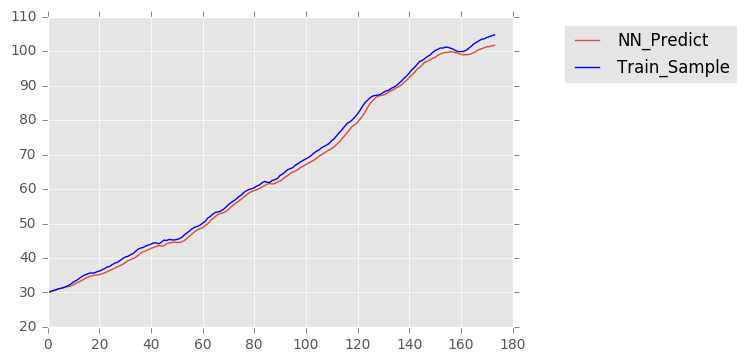

In [269]:
plt.plot(nn.predict(np.array(train_nn.iloc[:, :-1])), label='NN_Predict')
plt.plot(np.array(train_nn.iloc[:, -1]), color='blue', label='Train_Sample')
plt.legend(bbox_to_anchor=(1.5,1), loc='best')
plt.show()